In [ ]:
# !jupyter nbconvert --to script "initiell.ipynb"

In [1]:
import datetime as dt
import warnings
from datetime import datetime, timedelta
from math import sqrt
from time import sleep

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.core.interactiveshell import InteractiveShell
from pandas import DataFrame, Series
from shapely.geometry import Point, Polygon
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

import mplleaflet
import shap

warnings.simplefilter(action='ignore', category=FutureWarning)

InteractiveShell.ast_node_interactivity = "all"


/miniconda3/envs/tid37/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/miniconda3/envs/tid37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/miniconda3/envs/tid37/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instea

### Pre-dataloading

In [ ]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_riders = pd.read_csv('Riders.csv')

# Join rider info to train/test
df_train = pd.merge(df_train, df_riders, how='left', left_on=['Rider Id'], right_on=['Rider Id'])
df_test = pd.merge(df_test, df_riders, how='left', left_on=['Rider Id'], right_on=['Rider Id'])

In [ ]:
hexss = pd.read_json('travel_times/540_hexclusters.json')
dict_ = {}
for itm in hexss['features']:
    dict_[int(itm['properties']['MOVEMENT_ID'])] = Polygon(itm['geometry']['coordinates'][0])


In [ ]:
## Make pickup and destination points
df_train['pickup'] = [Point(row['Pickup Long'], row['Pickup Lat']) for i,row in df_train.iterrows()]
df_train['destination'] = [Point(row['Destination Long'], row['Destination Lat']) for i,row in df_train.iterrows()]

df_test['pickup'] = [Point(row['Pickup Long'], row['Pickup Lat']) for i,row in df_test.iterrows()]
df_test['destination'] = [Point(row['Destination Long'], row['Destination Lat']) for i,row in df_test.iterrows()]


## find the hex shape the points belong to
df_train['pickup_ID'] = df_train['pickup'].apply(lambda x: max([k if x.within(v) else -1 for k,v in dict_.items()]))
df_train['destination_ID'] = df_train['destination'].apply(lambda x: max([k if x.within(v) else -1 for k,v in dict_.items()]))

df_test['pickup_ID'] = df_test['pickup'].apply(lambda x: max([k if x.within(v) else -1 for k,v in dict_.items()]))
df_test['destination_ID'] = df_test['destination'].apply(lambda x: max([k if x.within(v) else -1 for k,v in dict_.items()]))


### Time 

In [ ]:
train_time_col = ['Placement', 'Confirmation', 'Arrival at Pickup', 'Pickup', 'Arrival at Destination']
test_time_col  = ['Placement', 'Confirmation', 'Arrival at Pickup', 'Pickup']
time_cat = ['Day of Month', 'Weekday (Mo = 1) ', 'Time']

for col in test_time_col:
    time_col = col + ' - Time'
    
    df_train[time_col] = pd.to_datetime(df_train[time_col])
    df_train[time_col+'_hour'] = df_train[time_col].dt.hour
    df_train[time_col] = df_train[time_col].dt.hour * 60 + df_train[time_col].dt.minute
    
    df_test[time_col] = pd.to_datetime(df_test[time_col])
    df_test[time_col+'_hour'] = df_test[time_col].dt.hour
    df_test[time_col] = df_test[time_col].dt.hour * 60 + df_test[time_col].dt.minute    

In [ ]:
cat_col = ['Personal or Business']
df_train['Personal or Business'] = df_train['Personal or Business'].astype('category').cat.codes
df_test['Personal or Business'] = df_test['Personal or Business'].astype('category').cat.codes

In [ ]:
## Save Pickle dataframes
df_train.to_pickle('df_train.pkl')
df_test.to_pickle('df_test.pkl')

## Start here

In [2]:
#### Read Pickled dataframes ############
df_train = pd.read_pickle('df_train.pkl')
df_test = pd.read_pickle('df_test.pkl')

In [3]:
## Merge the average travel times to the pickup and destination shapes
tt_weekly = pd.read_csv('travel_times/nairobi-hexclusters-2018-4-WeeklyAggregate.csv')

print ('Shape before merge:', df_train.shape)
df_train = pd.merge(df_train, tt_weekly
              , how='left'
              , left_on=['pickup_ID','destination_ID','Pickup - Weekday (Mo = 1)']
              , right_on=[ 'dstid','sourceid', 'dow']
              , suffixes=('_hour', '_week')
         )
print ('Shape after merge:', df_train.shape)
print ('Shape before merge:', df_test.shape)
df_test = pd.merge(df_test, tt_weekly
          , how='left'
              , left_on=['pickup_ID','destination_ID','Pickup - Weekday (Mo = 1)']
              , right_on=[ 'dstid','sourceid', 'dow']
              , suffixes=('_hour', '_week')
         )
print ('Shape after merge:', df_test.shape)

del tt_weekly

Shape before merge: (21201, 41)
Shape after merge: (21201, 48)
Shape before merge: (7068, 37)
Shape after merge: (7068, 44)


In [4]:
df_train.set_index('Order No', inplace=True)
df_test.set_index('Order No', inplace=True)

In [6]:
# ## Drop columns
drop_columns = []
drop_columns_train = ['Rider Id', 'pickup', 'destination', 'Vehicle Type'
                      , 'Arrival at Destination - Time', 'Arrival at Destination - Day of Month'
                      , 'Arrival at Destination - Weekday (Mo = 1)','dstid','sourceid', 'dow'
                      , 'Pickup - Time_hour']

drop_columns_test = ['Rider Id', 'pickup', 'Vehicle Type',
                     'destination','dstid','sourceid', 'dow', 'Pickup - Time_hour']

df_train = df_train.drop(drop_columns_train, axis=1)
df_test = df_test.drop(drop_columns_test, axis=1)

lable = df_train.pop('Time from Pickup to Arrival')

## Pipeline

In [7]:
class clusterer(BaseEstimator, TransformerMixin):
    """Clusters gtfs positions with hdbscan algorithm. Calls approximate_predict from transform.
       Copied from tidsmakin longterm pipeline """
    def __init__(self, min_cluster_size, columns, name):
        self.min_cluster_size = min_cluster_size
        self.columns= columns
        self.cluster = hdbscan.HDBSCAN(self.min_cluster_size, prediction_data=True, core_dist_n_jobs=-1)
        self.name = name
        self.feature_names = None


    def fit(self, X, y=None, **args):
        """Calls inner fit method. Requires X to have columns 'lon' and 'lat'."""
        self.cluster.fit(X[self.columns])
        return self
    
    def transform(self, X, y=None, **args):
        """Calls approximate_predict method. Requires X to have columns 'lon' and 'lat'."""
        X = X.copy()
        X[self.name] = hdbscan.approximate_predict(self.cluster, X[self.columns])[0]
        return X
    
    def fit_transform(self, X, y=None, **args):
        """Calls inner fit_transform method. Requires X to have columns 'lon' and 'lat'."""
        X = X.copy()
        X[self.name] = self.cluster.fit_predict(X[self.columns])
        return X


In [8]:
class averager(BaseEstimator, TransformerMixin):
    """takes a cluster and cerates averages"""
    
    def __init__(self, cluster_col, name, avg_col):
        self.cluster_col=cluster_col
        self.name = name
        self.avg_col = avg_col
        self.temp = None
        self.feature_names = None
        
    def fit(self, X, y=None, **args):
        X = X.copy()
        self.temp = X.groupby(by=self.cluster_col)[self.avg_col].mean().rename(self.name)
        return self
    
    def transform(self, X, y=None, **args):
        X = X.copy()
        X = pd.merge(X, self.temp, how='left', left_on=self.cluster_col, right_index=True)
        return X


In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, all_features=None, selected_features=None):
        """Constructor"""
        self.all_features = all_features
        self.selected_features = selected_features
        self.mask = np.isin(all_features, selected_features)
        
    def fit(self, X, y=None):
        """Do nothing"""
        return self
    
    def transform(self, X, y=None):
        """Filter columns based on selected_features"""
        return X[self.selected_features]
#         if isinstance(X, DataFrame):
#             return X.loc[:, self.mask]
#         else:
#             return X[:, self.mask]     

In [10]:
## Two pipelines

model = XGBRegressor()


## Add the names of features created in the pipeline to the selected features list - automate this!
selected_features=['Personal or Business', 
                   'Placement - Day of Month',
                   'Placement - Weekday (Mo = 1)', 
                   'Confirmation - Day of Month',
                   'Confirmation - Weekday (Mo = 1)', 
#                    'Confirmation - Time',
#                    'Arrival at Pickup - Day of Month',
                   'Arrival at Pickup - Weekday (Mo = 1)', 
#                    'Arrival at Pickup - Time',
                   'Pickup - Day of Month', 
#                    'Pickup - Weekday (Mo = 1)', 
                   'Pickup - Time',
#                    'Distance (KM)', 
                   'Destination Lat',
                   'Destination Long', 
                   'No_Of_Orders', 
                   'Age', 
                   'Average_Rating',
                   'No_of_Ratings', 
                   'pickup_ID', 
                   'destination_ID', 
                   'Placement - Time_hour',
                   'Confirmation - Time_hour', 
                   'Arrival at Pickup - Time_hour',
                   'mean_travel_time',
#                    'standard_deviation_travel_time', 
                    'geometric_mean_travel_time',
#                     'Pickup Lat', 'Pickup Long'
#                    'pickup_cluster',
#                    'dropoff_cluster',
#                    'trip_cluster',
#                    'pickup_avg',
#                    'Dropoff_avg',
#                    'pickup_avg'
                   
                     'trip_avg','Dropoff_avg','pickup_avg'
                   , 'pickup_cluster', 'dropoff_cluster'
                   , 'trip_cluster'
                   
                  ]

preprocess = Pipeline([
    ('Pickup_clusterer', clusterer(min_cluster_size=20, columns=['Pickup Lat', 'Pickup Long'], name= 'pickup_cluster')),
    ('Dropoff_clusterer', clusterer(min_cluster_size=20, columns=['Destination Lat', 'Destination Long'], name= 'dropoff_cluster')),
    ('Trip_clusterer', clusterer(min_cluster_size=10, columns=['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long'], name='trip_cluster')),
    ('Pickup_avg', averager(cluster_col=['pickup_cluster'], name='pickup_avg', avg_col='mean_travel_time')), 
    ('trip_avg', averager(cluster_col=['trip_cluster'], name='trip_avg', avg_col='mean_travel_time')), 
    ('Dropoff_avg', averager(cluster_col=['dropoff_cluster'], name='Dropoff_avg', avg_col='mean_travel_time')), 
])

my_pipeline= Pipeline([
    ('preprocess', preprocess),
    ('featureSelector', FeatureSelector(all_features=df_train.columns.tolist(), selected_features=selected_features )),
    ('Estimator', XGBRegressor(n_jobs=-1, min_child_weight=1, learning_rate=0.1, max_depth=4, n_estimators=400 ))
])

## Cross-validate

In [11]:
scores = cross_val_score(my_pipeline, df_train, lable, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print('Mean Absolute Error %2f' %sqrt((-1 * scores.mean())))

Mean Absolute Error 764.791459


one pipeline - to rule them all:                     769.320854
two pipeline - feature selector in second pipeline:  769.320854
two pipelines - feature selector in first pipeline : 769.320854

Å pakke ting inn i en eller to pipelines har ingenting å si!


749.371063 - 726.662699687515


748.848552, 

762.84814, 762.848142, 762.848142

768.172496, 768.952424, 761.971832, 763.887159, 763.132690

762.318764 - 743.164917057135

761.367317 - 744.727784575196 

761.458746 - 741.294873650194 

764.110400 - 745.093392694508 

987.677534, 785.500839, 768.550634, 769.223604

# Submit

In [12]:
# Fit model
pipe = my_pipeline.fit(df_train, lable)

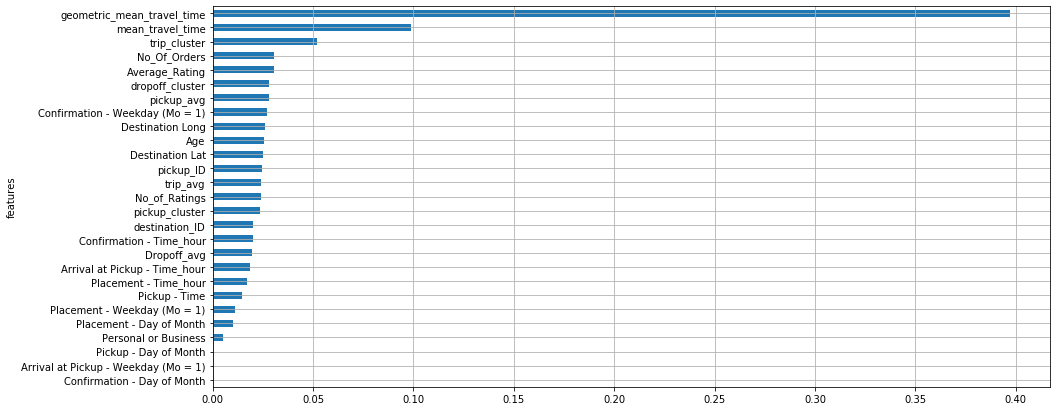

In [13]:
feature_importance = pd.DataFrame(list(zip(my_pipeline.named_steps['featureSelector'].selected_features, pipe.named_steps["Estimator"].feature_importances_)), columns=['features', 'importance'])
feature_importance.set_index('features', drop=True, inplace=True)
feature_importance.sort_values(by='importance', ascending=True, inplace=True)
feature_importance.plot(kind='barh', legend=False, grid=True, figsize=[15,7]);

In [263]:
# df_test_ = preprocess.named_steps['Pickup_clusterer'].transform(df_test)
# df_test_ = preprocess.named_steps['Dropoff_clusterer'].transform(df_test_)
# df_test_ = preprocess.named_steps['Trip_clusterer'].transform(df_test_)
# df_test_ = preprocess.named_steps['Pickup_avg'].transform(df_test_)
# df_test_ = my_pipeline.named_steps['featureSelector'].transform(df_test_)
pip = preprocess.fit(df_train)
df_test_ = preprocess.transform(df_train)


explainer = shap.TreeExplainer(pipe.named_steps['Estimator'])
shap_values = explainer.shap_values(df_test_)
shap.summary_plot(shap_values, df_test_, plot_type="bar")

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields User Id

In [ ]:
shap.summary_plot(shap_values, df_test_)

In [ ]:
for name in df_test_.columns:
    shap.dependence_plot(name, shap_values, df_test_, display_features=df_test_)

In [15]:
result = my_pipeline.predict(df_test)
ids = df_test.index
submit = pd.DataFrame({'Order_No':ids,'Time from Pickup to Arrival':result.astype(int)}).set_index('Order_No')
submit.to_csv('submit.csv')

## Grid Search

In [ ]:
params = {
         'Pickup_clusterer__min_cluster_size': [20, 60, 80],
         'Dropoff_clusterer__min_cluster_size': [20, 60, 80],
         'Trip_clusterer__min_cluster_size': [10, 20],
         'Estimator__max_depth': [2, 3, 4, 7],
         'Estimator__n_estimators': [50, 200, 400],
         'Estimator__min_child_weight': [1, 2],
         'Estimator__learning_rate': [0.1, 0.01, 0.5],
    }

grid = GridSearchCV(estimator=my_pipeline, param_grid= params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
grid.fit(df_train, lable)

In [ ]:
print ('Best score = %s' %sqrt(-1 * grid.best_score_))
print ('Best paramter combination = ', grid.best_params_)

In [ ]:
pred = grid.predict(df_test)

print ('rmse score = %s' %sqrt(-1 * pred.best_score_))

## Appendix (fint ord for junk)

In [ ]:
# model = XGBRegressor()

# selected_features=['Personal or Business', 
#                    'Placement - Day of Month',
#                    'Placement - Weekday (Mo = 1)', 
#                    'Confirmation - Day of Month',
#                    'Confirmation - Weekday (Mo = 1)', 
#                    'Confirmation - Time',
#                    'Arrival at Pickup - Day of Month',
#                    'Arrival at Pickup - Weekday (Mo = 1)', 
#                    'Arrival at Pickup - Time',
#                    'Pickup - Day of Month', 
#                    'Pickup - Weekday (Mo = 1)', 
#                    'Pickup - Time',
#                    'Distance (KM)', 
#                    'Destination Lat',
#                    'Destination Long', 
#                    'No_Of_Orders', 
#                    'Age', 
#                    'Average_Rating',
#                    'No_of_Ratings', 
#                    'pickup_ID', 
#                    'destination_ID', 
#                    'Placement - Time_hour',
#                    'Confirmation - Time_hour', 
#                    'Arrival at Pickup - Time_hour',
#                    'Pickup - Time_hour', 
#                    'mean_travel_time',
#                    'standard_deviation_travel_time', 
#                    'geometric_mean_travel_time',
# #                     ,'Pickup Lat', 'Pickup Long'
#                   ]

# preprocess = Pipeline([
#     ('Pickup_clusterer', clusterer(min_cluster_size=60, columns=['Pickup Lat', 'Pickup Long'], name= 'pickup_cluster')),
#     ('Dropoff_clusterer', clusterer(min_cluster_size=60, columns=['Destination Lat', 'Destination Long'], name= 'dropoff_cluster')),
#     ('Trip_clusterer', clusterer(min_cluster_size=10, columns=['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long'], name='trip_cluster')),
#     ('Pickup_avg', averager(cluster_col=['pickup_cluster'], name='pickup_avg', avg_col='geometric_mean_travel_time')), 
#     ('featureSelector', FeatureSelector(all_features=df_train.columns.tolist(), selected_features=selected_features )),
# ])
    
# my_pipeline = Pipeline([
#     ('preprocess',preprocess ),
#     ('Estimator', XGBRegressor(n_jobs=-1))
# ])
    

In [ ]:
# ### ONE PIPELINE

# model = XGBRegressor()

# selected_features=['Personal or Business', 
#                    'Placement - Day of Month',
#                    'Placement - Weekday (Mo = 1)', 
#                    'Confirmation - Day of Month',
#                    'Confirmation - Weekday (Mo = 1)', 
# #                    'Confirmation - Time',
# #                    'Arrival at Pickup - Day of Month',
#                    'Arrival at Pickup - Weekday (Mo = 1)', 
# #                    'Arrival at Pickup - Time',
#                    'Pickup - Day of Month', 
# #                    'Pickup - Weekday (Mo = 1)', 
#                    'Pickup - Time',
# #                    'Distance (KM)', 
#                    'Destination Lat',
#                    'Destination Long', 
#                    'No_Of_Orders', 
#                    'Age', 
#                    'Average_Rating',
#                    'No_of_Ratings', 
#                    'pickup_ID', 
#                    'destination_ID', 
#                    'Placement - Time_hour',
#                    'Confirmation - Time_hour', 
#                    'Arrival at Pickup - Time_hour',
#                    'mean_travel_time',
# #                    'standard_deviation_travel_time', 
#                     'geometric_mean_travel_time',
# #                     'Pickup Lat', 'Pickup Long'
# #                    'pickup_cluster',
# #                    'dropoff_cluster',
# #                    'trip_cluster',
# #                    'pickup_avg',
# #                    'Dropoff_avg',
# #                    'pickup_avg'
                   
#                    'trip_avg','Dropoff_avg','pickup_avg', 'pickup_cluster', 'dropoff_cluster'
#                    , 'trip_cluster'
#                   ]

# pre_columns = [    ]


# preprocess = Pipeline([
#     ('Pickup_clusterer', clusterer(min_cluster_size=20, columns=['Pickup Lat', 'Pickup Long'], name= 'pickup_cluster')),
#     ('Dropoff_clusterer', clusterer(min_cluster_size=20, columns=['Destination Lat', 'Destination Long'], name= 'dropoff_cluster')),
#     ('Trip_clusterer', clusterer(min_cluster_size=10, columns=['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long'], name='trip_cluster')),
#     ('Pickup_avg', averager(cluster_col=['pickup_cluster'], name='pickup_avg', avg_col='mean_travel_time')), 
#     ('trip_avg', averager(cluster_col=['trip_cluster'], name='trip_avg', avg_col='mean_travel_time')), 
#     ('Dropoff_avg', averager(cluster_col=['dropoff_cluster'], name='Dropoff_avg', avg_col='mean_travel_time')), 
#     ('featureSelector', FeatureSelector(all_features=df_train.columns.tolist(), selected_features=selected_features )),
# ])

# my_pipeline= Pipeline([
#     ('preprocess', preprocess),   
#     ('Estimator', XGBRegressor(n_jobs=-1, min_child_weight=1, learning_rate=0.1, max_depth=4, n_estimators=400 ))
# ])

In [ ]:
# ### ONE PIPELINE

# model = XGBRegressor()

# selected_features=['Personal or Business', 
#                    'Placement - Day of Month',
#                    'Placement - Weekday (Mo = 1)', 
#                    'Confirmation - Day of Month',
#                    'Confirmation - Weekday (Mo = 1)', 
# #                    'Confirmation - Time',
# #                    'Arrival at Pickup - Day of Month',
#                    'Arrival at Pickup - Weekday (Mo = 1)', 
# #                    'Arrival at Pickup - Time',
#                    'Pickup - Day of Month', 
# #                    'Pickup - Weekday (Mo = 1)', 
#                    'Pickup - Time',
# #                    'Distance (KM)', 
#                    'Destination Lat',
#                    'Destination Long', 
#                    'No_Of_Orders', 
#                    'Age', 
#                    'Average_Rating',
#                    'No_of_Ratings', 
#                    'pickup_ID', 
#                    'destination_ID', 
#                    'Placement - Time_hour',
#                    'Confirmation - Time_hour', 
#                    'Arrival at Pickup - Time_hour',
#                    'mean_travel_time',
# #                    'standard_deviation_travel_time', 
#                     'geometric_mean_travel_time',
# #                     'Pickup Lat', 'Pickup Long'
# #                    'pickup_cluster',
# #                    'dropoff_cluster',
# #                    'trip_cluster',
# #                    'pickup_avg',
# #                    'Dropoff_avg',
# #                    'pickup_avg'
                   
#                   ]

# my_pipeline = Pipeline([
#     ('Pickup_clusterer', clusterer(min_cluster_size=20, columns=['Pickup Lat', 'Pickup Long'], name= 'pickup_cluster')),
#     ('Dropoff_clusterer', clusterer(min_cluster_size=20, columns=['Destination Lat', 'Destination Long'], name= 'dropoff_cluster')),
#     ('Trip_clusterer', clusterer(min_cluster_size=10, columns=['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long'], name='trip_cluster')),
#     ('Pickup_avg', averager(cluster_col=['pickup_cluster'], name='pickup_avg', avg_col='mean_travel_time')), 
#     ('trip_avg', averager(cluster_col=['trip_cluster'], name='trip_avg', avg_col='mean_travel_time')), 
#     ('Dropoff_avg', averager(cluster_col=['dropoff_cluster'], name='Dropoff_avg', avg_col='mean_travel_time')), 
#     ('featureSelector', FeatureSelector(all_features=df_train.columns.tolist(), selected_features=selected_features )),
#     ('Estimator', XGBRegressor(n_jobs=-1, min_child_weight=1, learning_rate=0.1, max_depth=4, n_estimators=400 ))
# ])

## Plotting

In [ ]:
a, b = zip(*hexss['features'][0]['geometry']['coordinates'][0])

In [ ]:
coords = hexss['features'][0]['geometry']['coordinates'][0]
df_plot = df_train.sample(500)
#plt.hold(True)
#plt.plot(df_plot['Destination Long'], df_plot['Destination Lat'], 'r.')
#plt.plot(df_plot['Pickup Long'], df_plot['Pickup Lat'], 'b.')
plt.plot(a,b)
# Create the map. Save the file to basic_plot.html. _map.html is the default
# if 'path' is not specified
#mplleaflet.show(path=mapfile)
mplleaflet.display()